In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.stats import pearsonr 
from scipy import stats
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import timeit
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Chargement données DataFrame - data_elec

In [6]:
data_all = pd.read_csv('data_elec.csv').drop(['PropertyName','OSEBuildingID','SecondLargestPropertyUseType','LargestPropertyUseType','TaxParcelIdentificationNumber','CouncilDistrictCode','DataYear','DefaultData','ComplianceStatus'], axis=1)

In [7]:
#data_all.isin([np.inf, -np.inf])

# Feature Engineering

# Categorical feature selection

In [8]:
listCategorical = data_all.select_dtypes(include=['object']).columns

In [9]:
#df_categorical = data_all[['ListOfAllPropertyUseTypes','Neighborhood','BuildingType','PrimaryPropertyType']]
df_categorical = data_all[listCategorical]

In [10]:
data_all.head(2)

,BuildingType,PrimaryPropertyType,Neighborhood,ListOfAllPropertyUseTypes,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,NonResidential,Hotel,DOWNTOWN,"Hotel, Parking, Restaurant",1996.0,1.0,11.0,103566.0,15064.0,88502.0,83880.0,15064.0,56.0,8371084.0,279.685,2.62
1,NonResidential,Hotel,DOWNTOWN,"Hotel, Parking, Swimming Pool",1980.0,1.0,18.0,147735.0,37230.0,110505.0,123445.0,68009.0,71.0,14500852.5,506.355,3.45


# Feature Engineering - Généralisation Encodage des données

Encodage feature ListOfAllPropertyUseTypes

In [11]:
#def listSeparate(cate) :
#    cate_clean_lvl1 = cate.split(",")[0]
#    return cate_clean_lvl1

#df_AllPropertyUseTypesbycolumn = data_all['ListOfAllPropertyUseTypes'].apply(lambda x : listSeparate(x))
df_AllPropertyUseTypesbycolumn = data_all['ListOfAllPropertyUseTypes'].str.split(',', expand = True)

Verifie le nombre de NAN  par colonne

In [12]:
(df_AllPropertyUseTypesbycolumn.isnull().sum()*100)/len(df_AllPropertyUseTypesbycolumn)

0      0.000000
1      0.598802
2     59.161677
3     82.754491
4     91.736527
5     96.646707
6     98.922156
7     99.401198
8     99.520958
9     99.880240
10    99.880240
dtype: float64

In [13]:
#Analyse variétés des données
#Selectionner les labels avant le dummy
for i in range(2):
    print(df_AllPropertyUseTypesbycolumn[i].value_counts())

Office                                   313
Non-Refrigerated Warehouse               125
Parking                                   48
Data Center                               40
Hotel                                     37
Distribution Center                       37
Medical Office                            31
Multifamily Housing                       26
Fitness Center/Health Club/Gym            23
Other                                     23
Bank Branch                               16
Laboratory                                13
K-12 School                               11
Financial Office                          11
Food Service                               9
Automobile Dealership                      5
Food Sales                                 5
College/University                         5
Other - Entertainment/Public Assembly      5
Other - Recreation                         4
Bar/Nightclub                              4
Retail Store                               4
Convenienc

Creation d'une instance one-hot-encoder

In [14]:
#from dask_ml.preprocessing import DummyEncoder
#de = DummyEncoder()
encoder = OneHotEncoder(handle_unknown='ignore')

Performe un one-hot encoding sur la colonne 'ListOfAllPropertyUseTypes'

In [15]:
encoder_df = pd.DataFrame(encoder.fit_transform(df_AllPropertyUseTypesbycolumn[[0]]).toarray())
encoder_df.columns = encoder.get_feature_names_out()

La liste des catégories les plus nombreuses de la variable ListOfAllPropertyUseTypes

In [16]:
listAllPropertyUseTypes = df_AllPropertyUseTypesbycolumn[0].value_counts().index[0:3].tolist()

In [17]:
#Filtre sur les colonnes possédant les noms de la liste listBuilding
colsAllPropertyUseTypes=[]
for i in range(0,len(listAllPropertyUseTypes)):
    colsAllPropertyUseTypes.extend(encoder_df.filter(like=listAllPropertyUseTypes[i], axis=1).columns)

Merge du one-hot encoded colonnes avec le dataframe original 

In [18]:
df_data_allA = data_all.join(encoder_df[colsAllPropertyUseTypes])

In [19]:
df_data_allA.shape

(835, 21)

In [20]:
data_all.shape

(835, 16)

In [21]:
df_data_allA.shape

(835, 21)

In [22]:
df_data_allA.isna().mean()

BuildingType                       0.0
PrimaryPropertyType                0.0
Neighborhood                       0.0
ListOfAllPropertyUseTypes          0.0
YearBuilt                          0.0
NumberofBuildings                  0.0
NumberofFloors                     0.0
PropertyGFATotal                   0.0
PropertyGFAParking                 0.0
PropertyGFABuilding(s)             0.0
LargestPropertyUseTypeGFA          0.0
SecondLargestPropertyUseTypeGFA    0.0
ENERGYSTARScore                    0.0
SiteEnergyUse(kBtu)                0.0
TotalGHGEmissions                  0.0
GHGEmissionsIntensity              0.0
x0_Financial Office                0.0
x0_Medical Office                  0.0
x0_Office                          0.0
x0_Non-Refrigerated Warehouse      0.0
x0_Parking                         0.0
dtype: float64

#### Encodage features Neighborhood, BuildingType et PrimaryPropertyType

In [23]:
df_categorical['Neighborhood'].value_counts(normalize=True)

DOWNTOWN                 0.280240
GREATER DUWAMISH         0.201198
LAKE UNION               0.118563
MAGNOLIA / QUEEN ANNE    0.086228
EAST                     0.065868
NORTHEAST                0.058683
BALLARD                  0.035928
NORTHWEST                0.033533
NORTH                    0.028743
CENTRAL                  0.022754
DELRIDGE                 0.019162
SOUTHEAST                0.019162
SOUTHWEST                0.016766
North                    0.004790
Ballard                  0.003593
Delridge                 0.002395
Central                  0.002395
Name: Neighborhood, dtype: float64

In [24]:
#Creation de l'instance one-hot-encoder
encoder_2 = OneHotEncoder(handle_unknown='ignore')
df_Cate = pd.DataFrame(encoder_2.fit_transform(df_categorical[['Neighborhood','BuildingType','PrimaryPropertyType']]).toarray())
df_Cate.columns = encoder_2.get_feature_names_out()

Le but est de prendre en compte les catégories les plus nombreuses

In [25]:
#La liste des catégories les plus nombreuses de la variable BuildingType
listBuilding = df_categorical['BuildingType'].value_counts().index[0:1].tolist()

In [26]:
#La liste des catégories les plus nombreuses de la variable PrimaryPropertyType
listProperty = df_categorical['PrimaryPropertyType'].value_counts().index[0:2].tolist()

In [27]:
#La liste des catégories les plus nombreuses de la variable Neighborhood
listNeighborhood = df_categorical['Neighborhood'].value_counts().index[0:3].tolist()

In [28]:
#Filtre sur les colonnes possédant les noms de la liste listBuilding
colsBuilding=[]
for i in range(0,len(listBuilding)):
    colsBuilding.extend(df_Cate.filter(like=listBuilding[i], axis=1).columns)

In [29]:
#Filtre sur les colonnes possédant les noms de la liste listProperty
colsProperty=[]
for i in range(0,len(listProperty)):
    colsProperty.extend(df_Cate.filter(like=listProperty[i], axis=1).columns)

In [30]:
#Filtre sur les colonnes possédant les noms de la liste listNeighborhood
colsNeighborhood=[]
for i in range(0,len(listNeighborhood)):
    colsNeighborhood.extend(df_Cate.filter(like=listNeighborhood[i], axis=1).columns)

In [31]:
ListEncodage = colsBuilding+colsProperty+colsNeighborhood

In [32]:
#La liste Autre de la variable Neighborhood
#listNeighborhoodAutre = list(set(df_categorical['Neighborhood'].value_counts().index)-set(listNeighborhood))

In [33]:
df_data_allA.shape

(835, 21)

In [34]:
df_data_allB = df_data_allA.join(df_Cate[ListEncodage])

Suppression des colonnes catégorielles non encodées

In [35]:
df_data_all = df_data_allB.drop(df_categorical.columns, axis=1)

In [36]:
df_data_all.shape

(835, 23)

In [37]:
df_data_all.isna().mean()

YearBuilt                                          0.0
NumberofBuildings                                  0.0
NumberofFloors                                     0.0
PropertyGFATotal                                   0.0
PropertyGFAParking                                 0.0
PropertyGFABuilding(s)                             0.0
LargestPropertyUseTypeGFA                          0.0
SecondLargestPropertyUseTypeGFA                    0.0
ENERGYSTARScore                                    0.0
SiteEnergyUse(kBtu)                                0.0
TotalGHGEmissions                                  0.0
GHGEmissionsIntensity                              0.0
x0_Financial Office                                0.0
x0_Medical Office                                  0.0
x0_Office                                          0.0
x0_Non-Refrigerated Warehouse                      0.0
x0_Parking                                         0.0
BuildingType_NonResidential                        0.0
PrimaryPro

# Etude de corrélation : SiteEnergyUse(kBtu) et variables

# Corrélation - Pearson

Les corrélations entre la variable SiteEnergyUse(kBtu) et les autres features

In [38]:
featureCorrele = []
for i in df_data_all.columns:
    corr, pvalue = stats.pearsonr(df_data_all['SiteEnergyUse(kBtu)'], df_data_all[i])
    if corr > 0.76:
        featureCorrele.append(i)

In [39]:
#Les unités sont similaires d'ou la corrélation importantes entre ces variables et la variable target
#lien entre kBtu et kWh
featureCorrele

['PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions']

In [40]:
for i in df_data_all.columns:
    print("Coefficient de correlation linéaire (SiteEnergyUse(kBtu) et "+i+"):\n"+str(stats.pearsonr(df_data_all['SiteEnergyUse(kBtu)'], df_data_all[i])[0])+"\n")

Coefficient de correlation linéaire (SiteEnergyUse(kBtu) et YearBuilt):
0.216566062140716

Coefficient de correlation linéaire (SiteEnergyUse(kBtu) et NumberofBuildings):
0.3226768856129189

Coefficient de correlation linéaire (SiteEnergyUse(kBtu) et NumberofFloors):
0.5653619442774647

Coefficient de correlation linéaire (SiteEnergyUse(kBtu) et PropertyGFATotal):
0.8011758159367086

Coefficient de correlation linéaire (SiteEnergyUse(kBtu) et PropertyGFAParking):
0.4806652005480202

Coefficient de correlation linéaire (SiteEnergyUse(kBtu) et PropertyGFABuilding(s)):
0.7997669552737524

Coefficient de correlation linéaire (SiteEnergyUse(kBtu) et LargestPropertyUseTypeGFA):
0.8016842865773794

Coefficient de correlation linéaire (SiteEnergyUse(kBtu) et SecondLargestPropertyUseTypeGFA):
0.677125312714102

Coefficient de correlation linéaire (SiteEnergyUse(kBtu) et ENERGYSTARScore):
0.04414964379596671

Coefficient de correlation linéaire (SiteEnergyUse(kBtu) et SiteEnergyUse(kBtu)):
1.0



# Correlation - ACP

In [41]:
from sklearn import decomposition,preprocessing

In [42]:
#Centrage et Réduction pour l'ACP
X_scaled_ACP = preprocessing.StandardScaler().fit_transform(df_data_all)

In [43]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=len(df_data_all.columns))
X_projected = pca.fit_transform(X_scaled_ACP)

In [44]:
df_acp = pd.DataFrame()

In [45]:
#Calcul des composantes principales
for u in range(len(df_data_all.columns)):
    df_acp["F"+str(u+1)] = pca.components_[u].tolist()

In [46]:
df_acp.set_axis(df_data_all.columns, axis='index')

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23
YearBuilt,0.109253,0.085768,-0.195359,-0.508880,0.076561,-0.195524,-0.017281,0.008190,0.257696,-0.275683,...,0.151755,-0.228085,-0.114014,-0.106417,-0.027771,-0.222515,0.066517,-0.013145,-0.006491,-1.108083e-16
NumberofBuildings,0.092418,0.245966,0.051139,0.217316,0.450318,-0.042723,0.117828,0.011055,0.297558,0.366548,...,-0.063277,0.296919,-0.082192,0.045083,-0.232906,-0.155655,-0.134056,0.014997,-0.012991,-1.422801e-16
NumberofFloors,0.308429,-0.161819,0.015663,0.053604,-0.221515,-0.000170,-0.007934,0.010681,0.016487,-0.113255,...,-0.232782,-0.075549,-0.274165,0.466611,-0.017630,-0.359086,-0.559485,-0.057818,0.044547,1.697077e-16
PropertyGFATotal,0.379677,0.029383,-0.082614,0.052670,0.027336,0.049257,-0.027331,-0.074891,0.056109,-0.010214,...,0.030921,0.022191,0.057268,0.075118,-0.103209,-0.012344,0.285674,-0.054985,0.390419,7.456774e-01
PropertyGFAParking,0.270994,-0.096651,-0.136390,-0.240381,-0.094732,0.043291,0.041142,-0.009905,0.072477,-0.135137,...,-0.105732,0.806729,-0.124854,-0.135874,0.088137,0.190507,0.011335,-0.052720,0.041669,-1.716811e-01
PropertyGFABuilding(s),0.367488,0.059805,-0.059316,0.125105,0.056923,0.045507,-0.042626,-0.084099,0.045659,0.024206,...,0.064009,-0.189424,0.099624,0.123237,-0.143042,-0.065098,0.327853,-0.049627,0.441082,-6.438096e-01
LargestPropertyUseTypeGFA,0.371045,0.045148,-0.064481,0.083891,0.033010,0.036297,-0.049718,-0.075920,0.064779,-0.003536,...,-0.031944,-0.052195,0.033475,0.204794,-0.017885,-0.036619,0.355727,-0.153698,-0.789025,-1.986780e-16
SecondLargestPropertyUseTypeGFA,0.326500,0.029302,-0.092125,-0.034933,0.055919,0.102214,-0.025961,-0.022401,-0.016233,-0.020229,...,0.215540,-0.103955,0.389424,-0.429142,-0.396449,0.087187,-0.509986,-0.006309,-0.126712,-1.099889e-16
ENERGYSTARScore,0.094568,-0.258544,-0.146166,0.019817,0.133943,-0.312553,0.128593,-0.100170,-0.278350,0.577239,...,-0.078374,-0.023562,-0.026918,-0.012699,0.026011,-0.023281,-0.008007,0.047365,0.002433,2.696713e-17
SiteEnergyUse(kBtu),0.337846,0.201775,0.114631,0.026880,0.092797,0.075541,-0.082987,0.045150,-0.074922,-0.043697,...,-0.029663,-0.079031,-0.098666,-0.048746,0.336684,0.111371,-0.044670,0.804573,-0.039884,-1.992490e-16


Graphe Ebouli

Text(0.5, 1.0, 'Diagramme de Pareto - Ebouli')

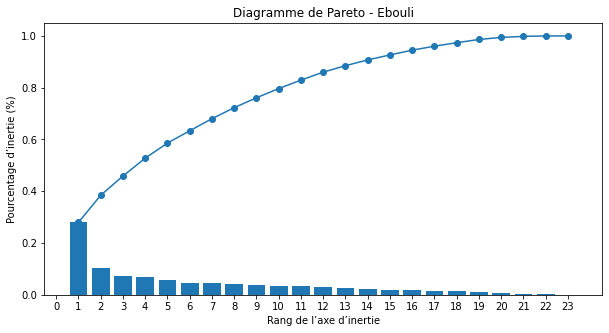

In [47]:
#Diagramme de Pareto - Ebouli
fig = plt.figure(figsize = (10, 5))
x = np.arange(1, len(df_data_all.columns)+1, step=1)
y = pca.explained_variance_ratio_
#Affiche le bar chart
plt.bar(np.arange(1, len(df_data_all.columns)+1, step=1),pca.explained_variance_ratio_)
#Affiche la courbe sommée
plt.plot(x,np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xticks(np.arange(0, len(df_data_all.columns)+1, step=1))
plt.ylabel('Pourcentage d’inertie (%)')
plt.xlabel('Rang de l’axe d’inertie')
plt.title('Diagramme de Pareto - Ebouli')
#plt.savefig('Ebouli.png')

Cadran PCA - 100/30 - F1/F2 et F3/F4

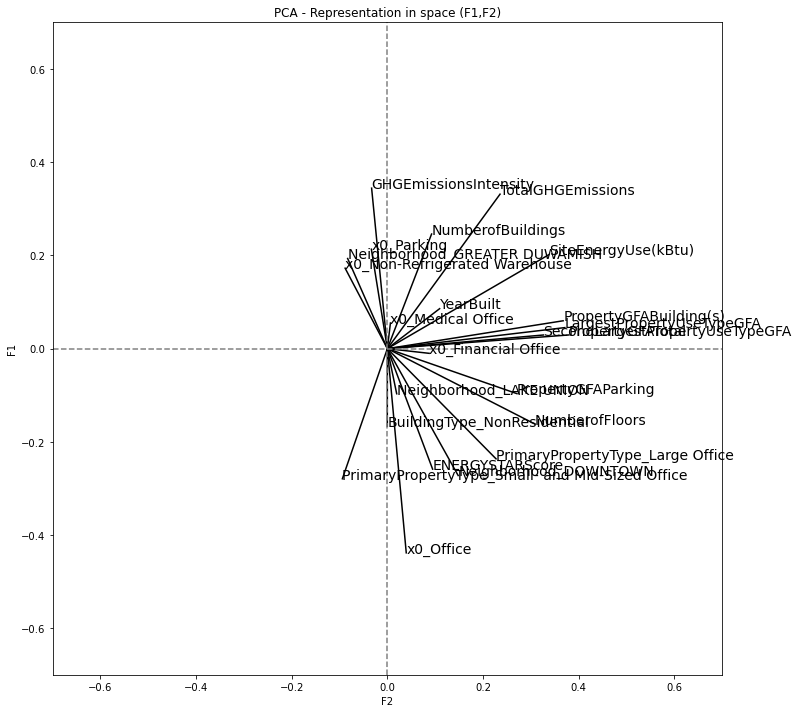

In [156]:
pcs = pca.components_
plt.figure(figsize=(12,12))
plt.xlabel('F2')
plt.ylabel('F1')
plt.title('PCA - Representation in space (F1,F2)')
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Display a segment from origin to the point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Display the name of the feature (df_data_all.columns[i])
    plt.text(x, y, df_data_all.columns[i], fontsize='14')

# Display an horizontal line y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Display vertical line x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])
#plt.savefig('ACP.png')

In [49]:
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(X_projected[:,0],X_projected[:,1])
#A réecrire
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(leafNt[:,0],leafNt[:,1],leafNt[:,2])
#plt.show()

# Etude Consommation Totale d'énergie - SiteEnergyUse(kBtu)

<AxesSubplot:title={'center':'Distribution de SiteEnergyUse(kBtu)'}, xlabel='SiteEnergyUse(kBtu)', ylabel='Count'>

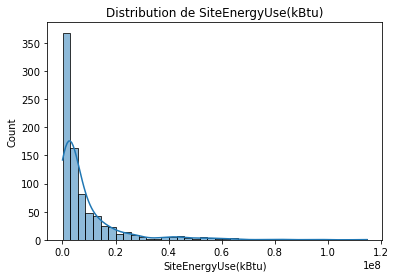

In [50]:
plt.title('Distribution de SiteEnergyUse(kBtu)')
sns.histplot(df_data_all['SiteEnergyUse(kBtu)'], bins=40, kde=True)

Transformation logarithmique

In [51]:
Y_log = np.log(df_data_all['SiteEnergyUse(kBtu)'])

<AxesSubplot:title={'center':'Distribution de SiteEnergyUse(kBtu) après transformation log'}, xlabel='SiteEnergyUse(kBtu)', ylabel='Count'>

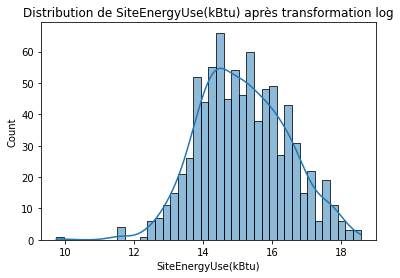

In [52]:
plt.title('Distribution de SiteEnergyUse(kBtu) après transformation log')
sns.histplot(Y_log, bins=40, kde=True)

## Création Jeux de données de test et d'entrainement

On crée notre variable cible Y, SiteEnergyUse(kBtu)

Notre variable X contient les variables à étudier à l'exception des variables corrélés à 'SiteEnergyUse(kBtu)'

In [53]:
X = df_data_all.drop(featureCorrele, axis=1)
Y = Y_log
# on crée un jeux de données d'entrainement et de test avec 30% des données dans le jeu de test
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y,test_size=0.3, random_state=42)

Feature Engineering - Standardisation des données

In [54]:
#On réduit et on norme les données
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

ScoreBoard

In [55]:
results = pd.DataFrame(columns = ['Type de modele','Best Score', 'Hyperparametres','Temps execution'])

### Linear Regression - Target variable SiteEnergyUse(kBtu)

In [56]:
linear = LinearRegression()

#### Cross-Validation - 5 folds

Tester la performance de mon modèle en découpant le jeux de données en 5 parties

(tour à tour chaque partie est utilisée comme jeux de test)

In [57]:
r2_scores = cross_validate(linear,X_train_std,Y_train,cv=5,scoring='r2')

In [58]:
print("Mean 5 folds R2 : {}".format(np.mean(r2_scores['test_score'])))

Mean 5 folds R2 : 0.6064285192972113


#### Linear Regression

In [59]:
#Mesure temps de calcul - Départ
start_time = timeit.default_timer()

In [60]:
linear.fit(X_train_std, Y_train)

LinearRegression()

In [61]:
y_test_pred = linear.predict(X_test_std)

In [62]:
np.isfinite(Y_test.all())

True

In [63]:
#Mesure temps de calcul - Fin
elapsed = timeit.default_timer() - start_time
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_pred)))
r2 = r2_score(Y_test, y_test_pred)

R2 score qui permet de mesurer la précision du modèle

In [64]:
print("R2 {:.2f} time {:.2f}s".format(r2, elapsed))

R2 0.63 time 0.07s


Racine carré de l'Erreur Quadratique moyenne

In [65]:
rmse

0.7327702484610175

In [66]:
df_data_all['SiteEnergyUse(kBtu)'].describe()

count    8.350000e+02
mean     8.418778e+06
std      1.315470e+07
min      1.697945e+04
25%      1.549211e+06
50%      3.484280e+06
75%      9.261157e+06
max      1.148643e+08
Name: SiteEnergyUse(kBtu), dtype: float64

In [67]:
results = pd.concat([results, pd.DataFrame.from_records([{'Type de modele' : 'Regression lineaire',
                          'Best Score' : r2,
                          'Hyperparametres' : '',
                          'Temps execution' : elapsed}])])

#### Vérification des valeurs prédites et actuelles

In [68]:
#pd.DataFrame(data={Y_test,y_test_pred})

#### Importance des variables - régréssion linéaire

In [69]:
list(zip(X.columns,linear.coef_))

[('YearBuilt', 0.18765849339532759),
 ('NumberofBuildings', 0.11130288316951571),
 ('NumberofFloors', 0.12440071100000333),
 ('PropertyGFAParking', 0.17711249446889535),
 ('SecondLargestPropertyUseTypeGFA', 0.39244688788632515),
 ('ENERGYSTARScore', -0.18234708208378278),
 ('GHGEmissionsIntensity', 0.49829279789310477),
 ('x0_Financial Office', -0.045792443259476553),
 ('x0_Medical Office', 0.010746262576984248),
 ('x0_Office', -0.11891633481695552),
 ('x0_Non-Refrigerated Warehouse', -0.1545962011058107),
 ('x0_Parking', -0.02102089751986623),
 ('BuildingType_NonResidential', -0.03502935989175575),
 ('PrimaryPropertyType_Small- and Mid-Sized Office', 0.050656764521873225),
 ('PrimaryPropertyType_Large Office', 0.3841854563797966),
 ('Neighborhood_DOWNTOWN', 0.19886969402447796),
 ('Neighborhood_GREATER DUWAMISH', 0.03235323979128721),
 ('Neighborhood_LAKE UNION', 0.09603856906250426)]

In [70]:
#features = X.columns
#Classement des variables par ordre d'importance
features_i_ela = list(zip(X.columns,linear.coef_))
features_i_ela.sort(key = lambda x : x[1])

Les features NaturalGas(therms) et NaturalGas(kBtu) ont réellement de l'importance

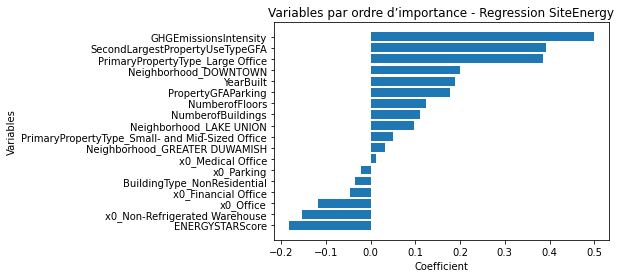

In [71]:
#Affichage des variables par ordre d'importance
plt.title('Variables par ordre d’importance - Regression SiteEnergy')
plt.ylabel('Variables')
plt.xlabel('Coefficient')
plt.barh([x[0] for x in features_i_ela],[x[1] for x in features_i_ela])
plt.show()

### Elastic Net - Target variable SiteEnergyUse(kBtu)

J'utilise le modèle Elastic Net pour savoir s'il est préférable d'utiliser le modèle Ridge ou Lasso

In [72]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [73]:
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5, tol=1e+1).fit(X_train_std, Y_train)

#### Cross-Validation - 5 folds 

On effectue une cross-validation avec différentes valeurs pour les hyperparamètre : alpha, l1_ratio

In [74]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid_elas = GridSearchCV(estimator=elastic_net, 
                         param_grid=param_grid, 
                         scoring='r2', 
                         verbose=1, 
                         n_jobs=-1, 
                         cv= 5)
grid_elas_result = grid_elas.fit(X_train_std, Y_train)

Fitting 5 folds for each of 77 candidates, totalling 385 fits


Suite au résultat, on constate que le l1_ratio est à 0.3, le modèle Lasso est à éviter

Le score est moins pertinent qu'une régréssion linéaire classique (sans modification des hyperparamètres)

In [75]:
print('Meilleur Score : ', grid_elas_result.best_score_)
print('Meilleur Paramètre : ', grid_elas_result.best_params_)

Meilleur Score :  0.5329758995877789
Meilleur Paramètre :  {'alpha': 1, 'l1_ratio': 0}


### Elastic Net with best hyperparameters

In [76]:
#Mesure temps de calcul - Départ
start_time_elas = timeit.default_timer()

In [77]:
elastic_net1 = ElasticNet(alpha=grid_elas_result.best_params_['alpha'], l1_ratio=grid_elas_result.best_params_['l1_ratio'], tol=1e+1).fit(X_train_std, Y_train)

In [78]:
elastic_net1.fit(X_train_std, Y_train)

ElasticNet(alpha=1, l1_ratio=0, tol=10.0)

In [79]:
y_train_pred_elastic = elastic_net1.predict(X_test_std)

In [80]:
#Mesure temps de calcul - Fin
elapsed_elas = timeit.default_timer() - start_time_elas

In [81]:
r2_elas = r2_score(Y_test, y_train_pred_elastic)

In [82]:
print("R2 {:.2f} time {:.2f}s".format(r2_elas, elapsed_elas))

R2 0.58 time 0.15s


In [83]:
#elastic_net1.fit(X_train_std, Y_train)
#y_train_pred_elastic = elastic_net1.predict(X_test_std)
#elapsed_elas = timeit.default_timer() - start_time_elas
#r2_elas = r2_score(Y_test, y_train_pred_elastic)

In [84]:
results = pd.concat([results, pd.DataFrame.from_records([{'Type de modele' : 'Elastic Net',
                          'Best Score' : r2_elas,
                          'Hyperparametres' : grid_elas_result.best_params_,
                          'Temps execution' : elapsed_elas}])])

Importance des features - Elastic Net

Le R2 du modèle elastic est inférieur à la régression linéaire classique (sans hyperparamètre), la régréssion linéaire classique est préférable

In [85]:
v =[]
for coef, col in enumerate(X_train.columns):
    print(f'{col}:  {elastic_net1.coef_[coef]}')
    v.append(elastic_net1.coef_[coef])

YearBuilt:  0.20423852301961726
NumberofBuildings:  0.08149968351014591
NumberofFloors:  0.3038194455211458
PropertyGFAParking:  0.1819207239719563
SecondLargestPropertyUseTypeGFA:  0.19628223357753763
ENERGYSTARScore:  -0.08349512222281551
GHGEmissionsIntensity:  0.21947773210770938
x0_Financial Office:  0.00931820484634834
x0_Medical Office:  0.013432502640111029
x0_Office:  0.008179323708605128
x0_Non-Refrigerated Warehouse:  -0.10418959639605428
x0_Parking:  -0.0012831699664674536
BuildingType_NonResidential:  -0.02081670896785692
PrimaryPropertyType_Small- and Mid-Sized Office:  -0.06439073167143676
PrimaryPropertyType_Large Office:  0.14292374925917384
Neighborhood_DOWNTOWN:  0.07704783237382934
Neighborhood_GREATER DUWAMISH:  -0.03143401492715198
Neighborhood_LAKE UNION:  0.03575052815207372


In [86]:
features = X.columns
#Classement des variables par ordre d'importance
features_i_ela = list(zip(features,v)) 
features_i_ela.sort(key = lambda x : x[1])

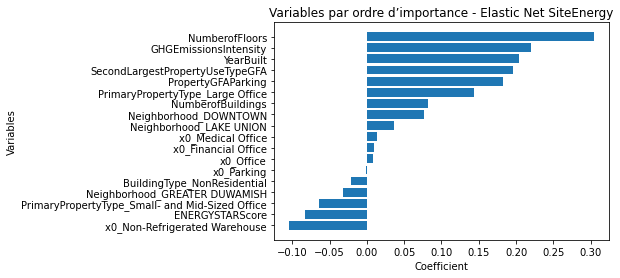

In [87]:
#Affichage des variables par ordre d'importance
plt.title('Variables par ordre d’importance - Elastic Net SiteEnergy')
plt.ylabel('Variables')
plt.xlabel('Coefficient')
plt.barh([x[0] for x in features_i_ela],[x[1] for x in features_i_ela])
plt.show()
#plt.savefig('Coef - Elastic Net SiteEnergy.png')

# Random Forest Regressor - Target variable SiteEnergyUse(kBtu)

Les données sont numériques et non-binaires, on a utilisé le random forest regressor 

#### Cross-Validation - 5 folds

On fait une cross-validation avec différentes valeurs pour les hyperparamètre : n_estimators, max_features, max_depth

In [88]:
rfr1 = RandomForestRegressor(random_state=42)

In [89]:
param_grid = { 
    'n_estimators': [10,20,30],
    'max_features': ['auto', 'sqrt', 'log2'],
    #'max_features': [10, 15, 27],
    'max_depth' : [4,5,6]
}

In [90]:
CV_grid_rfr = GridSearchCV(estimator=rfr1, 
                           param_grid=param_grid, 
                           cv= 5)
CV_grid_rfr_result = CV_grid_rfr.fit(X_train, Y_train)

In [91]:
CV_grid_rfr_result.best_params_

{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 30}

In [92]:
print('Meilleur Score : ', CV_grid_rfr_result.best_score_)
print('Meilleur Paramètre : ', CV_grid_rfr_result.best_params_)

Meilleur Score :  0.7337230537494545
Meilleur Paramètre :  {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 30}


In [93]:
#rfr1.predict(X_test)
#print("accuracy {:.2f}".format(accuracy_score(Y_test, pred)))
#rfr1.score(X_test, Y_test)

### Application of best hyperparameters

In [94]:
#Mesurer le temps de calcul - Départ
start_time = timeit.default_timer()

In [95]:
rfr = RandomForestRegressor(n_estimators=CV_grid_rfr_result.best_params_['n_estimators'],max_features=CV_grid_rfr_result.best_params_['max_features'],max_depth=CV_grid_rfr_result.best_params_['max_depth'], oob_score=True,random_state=42)

In [96]:
model = rfr.fit(X_train, Y_train)
y_test_prd_Random = rfr.predict(X_test)
elapsed = timeit.default_timer() - start_time #Mesurer le temps de calcul - Fin
accuracy = rfr.score(X_test, Y_test)

In [97]:
#R2 squarred et performance temporelle
print("accuracy {:.2f} time {:.2f}s".format(accuracy, elapsed))

accuracy 0.77 time 0.13s


In [98]:
results = pd.concat([results, pd.DataFrame.from_records([{'Type de modele' : 'Random Forest',
                          'Best Score' : accuracy,
                          'Hyperparametres' : CV_grid_rfr_result.best_params_,
                          'Temps execution' : elapsed}])])

RMSE

In [99]:
#RMSE
(np.sqrt(mean_squared_error(Y_test, y_test_prd_Random)))

0.5820157867480837

In [100]:
df_data_all['SiteEnergyUse(kBtu)'].describe()

count    8.350000e+02
mean     8.418778e+06
std      1.315470e+07
min      1.697945e+04
25%      1.549211e+06
50%      3.484280e+06
75%      9.261157e+06
max      1.148643e+08
Name: SiteEnergyUse(kBtu), dtype: float64

Importance des variables - Random Forest

In [101]:
features = X.columns

In [102]:
#Classement des variables par ordre d'importance
features_i = list(zip(features,rfr.feature_importances_)) 
features_i.sort(key = lambda x : x[1]) 

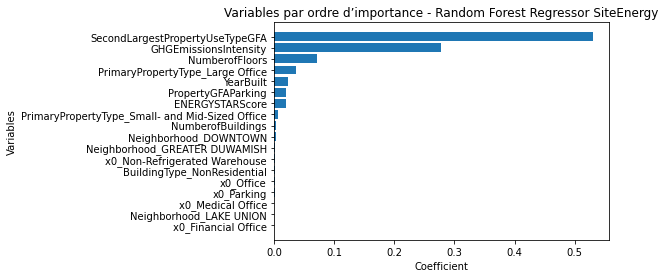

In [103]:
#Affichage des variables par ordre d'importance
plt.barh([x[0] for x in features_i],[x[1] for x in features_i])
plt.title('Variables par ordre d’importance - Random Forest Regressor SiteEnergy')
plt.ylabel('Variables')
plt.xlabel('Coefficient')
#plt.savefig('Coef - Random Forest Regressor SiteEnergy.png')
plt.show()

In [104]:
results

,Type de modele,Best Score,Hyperparametres,Temps execution
0,Regression lineaire,0.630129,,0.066803
0,Elastic Net,0.576653,"{'alpha': 1, 'l1_ratio': 0}",0.145057
0,Random Forest,0.766663,"{'max_depth': 6, 'max_features': 'auto', 'n_es...",0.134442


# Correlation study : TotalGHGEmissions et variables

# Correlation - Pearson

In [105]:
from scipy import stats

In [106]:
for i in df_data_all.columns:
    print("Coefficient de correlation (TotalGHGEmissions et "+i+"):\n"+str(stats.pearsonr(df_data_all['TotalGHGEmissions'], df_data_all[i])[0])+"\n")

Coefficient de correlation (TotalGHGEmissions et YearBuilt):
0.10720213765151017

Coefficient de correlation (TotalGHGEmissions et NumberofBuildings):
0.3696868110780578

Coefficient de correlation (TotalGHGEmissions et NumberofFloors):
0.27970086973694974

Coefficient de correlation (TotalGHGEmissions et PropertyGFATotal):
0.5247988759455291

Coefficient de correlation (TotalGHGEmissions et PropertyGFAParking):
0.21268741833996915

Coefficient de correlation (TotalGHGEmissions et PropertyGFABuilding(s)):
0.551119924247573

Coefficient de correlation (TotalGHGEmissions et LargestPropertyUseTypeGFA):
0.5483098402085143

Coefficient de correlation (TotalGHGEmissions et SecondLargestPropertyUseTypeGFA):
0.46176418168841443

Coefficient de correlation (TotalGHGEmissions et ENERGYSTARScore):
-0.04324280570535786

Coefficient de correlation (TotalGHGEmissions et SiteEnergyUse(kBtu)):
0.8131571767908022

Coefficient de correlation (TotalGHGEmissions et TotalGHGEmissions):
1.0

Coefficient de 

In [107]:
featureCorreleEmission = []
for i in df_data_all.columns:
    corr, pvalue = stats.pearsonr(df_data_all['TotalGHGEmissions'], df_data_all[i])
    if corr > 0.75:
        featureCorreleEmission.append(i)

In [108]:
#Les unités sont similaires d'ou la corrélation importantes entre ces variables et la variable target
#lien entre kBtu et kWh
featureCorreleEmission

['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

# Study TotalGHGEmissions

## Création Jeux de données de test et d'entrainement

<AxesSubplot:title={'center':'Distribution de TotalGHGEmissions'}, xlabel='TotalGHGEmissions', ylabel='Count'>

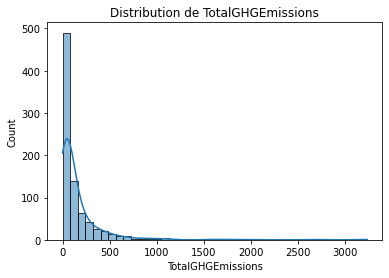

In [109]:
plt.title('Distribution de TotalGHGEmissions')
sns.histplot(df_data_all['TotalGHGEmissions'], bins=40, kde=True)

Transformation logarithmique dela variable cible TotalGHGEmissions

In [110]:
df_data_all.shape

(835, 23)

In [111]:
#On supprime une ligne possédant une des emissions nulles
df_data_all = df_data_all[df_data_all['TotalGHGEmissions']!=0]

In [112]:
Y_Em_log = np.log(df_data_all['TotalGHGEmissions'])

<AxesSubplot:title={'center':'Distribution de SiteEnergyUse(kBtu) après transformation log'}, xlabel='TotalGHGEmissions', ylabel='Count'>

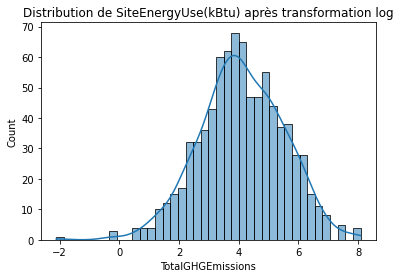

In [113]:
plt.title('Distribution de SiteEnergyUse(kBtu) après transformation log')
sns.histplot(Y_Em_log, bins=40, kde=True)

In [114]:
X_Em = df_data_all.drop(featureCorreleEmission, axis=1)
Y_Em = Y_Em_log
# 30% des données dans le jeu de test
X_train_Em, X_test_Em, Y_train_Em, Y_test_Em = model_selection.train_test_split(X_Em, Y_Em,test_size=0.3, random_state=42)

Feature Engineering - Standardisation of datas

In [115]:
std_scale = preprocessing.StandardScaler().fit(X_train_Em)
X_train_std_Em = std_scale.transform(X_train_Em)
X_test_std_Em = std_scale.transform(X_test_Em)

ScoreBoard

In [116]:
results_Em = pd.DataFrame(columns = ['Type de modele','Best Score', 'Hyperparametres','Temps execution'])

### Linear Regression - Target variable TotalGHGEmissions

In [117]:
linear_Em = LinearRegression()

#### Cross validation - 5 folds

In [118]:
r2_scores_Em = cross_validate(linear,X_train_std_Em,Y_train_Em,cv=5,scoring='r2')

In [119]:
print("Mean 5 folds R2 : {}".format(np.mean(r2_scores_Em['test_score'])))

Mean 5 folds R2 : 0.611231616400001


Linear Regression

In [120]:
#Mesure temps de calcul - Départ
start_time = timeit.default_timer()

In [121]:
linear_Em.fit(X_train_std_Em, Y_train_Em)

LinearRegression()

In [122]:
y_test_pred_Em = linear_Em.predict(X_test_std_Em)

In [123]:
#Mesure temps de calcul - Fin
elapsed = timeit.default_timer() - start_time
rmse = (np.sqrt(mean_squared_error(Y_test_Em, y_test_pred_Em)))
r2_Em = r2_score(Y_test_Em, y_test_pred_Em)

R2

In [124]:
print("R2 {:.2f} time {:.2f}s".format(r2_Em, elapsed))

R2 0.57 time 0.04s


In [125]:
results_Em = pd.concat([results_Em, pd.DataFrame.from_records([{'Type de modele' : 'Regression lineaire',
                          'Best Score' : r2_Em,
                          'Hyperparametres' : '',
                          'Temps execution' : elapsed}])])

#### Features Importance

In [126]:
list(zip(X_Em.columns,linear_Em.coef_))

[('YearBuilt', 0.12295923124172338),
 ('NumberofBuildings', 0.08233005535987832),
 ('NumberofFloors', -0.11303430266704599),
 ('PropertyGFATotal', 0.32275648338379187),
 ('PropertyGFAParking', 0.06992993462167137),
 ('PropertyGFABuilding(s)', 0.36074508103996356),
 ('LargestPropertyUseTypeGFA', -0.046698052612424164),
 ('SecondLargestPropertyUseTypeGFA', 0.0364875637285701),
 ('ENERGYSTARScore', -0.11885474162029273),
 ('GHGEmissionsIntensity', 0.8542420242597727),
 ('x0_Financial Office', -0.01580671130375086),
 ('x0_Medical Office', 0.030041925393318084),
 ('x0_Office', -0.13324516491986058),
 ('x0_Non-Refrigerated Warehouse', -0.11817928524602166),
 ('x0_Parking', -0.05736969208039322),
 ('BuildingType_NonResidential', -0.024423889357728015),
 ('PrimaryPropertyType_Small- and Mid-Sized Office', -0.04031849688704717),
 ('PrimaryPropertyType_Large Office', 0.2481999065427161),
 ('Neighborhood_DOWNTOWN', 0.1820366819755546),
 ('Neighborhood_GREATER DUWAMISH', -0.005914806694082539),
 (

### Elastic Net - Variable cible TotalGHGEmissions

Après une régression linéaire classique, j'utilise le modèle Elastic Net pour savoir s'il est préférable d'utiliser le modèle Ridge ou Lasso

In [127]:
elastic_net_Em = ElasticNet(alpha=1, l1_ratio=0.5, tol=1e+1).fit(X_train_std, Y_train)

#### Cross-Validation - 5 folds

On fait une cross-validation avec différentes valeurs pour les hyperparamètre : alpha, l1_ratio

In [128]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid_elas_Em = GridSearchCV(estimator=elastic_net_Em, 
                            param_grid=param_grid, 
                            scoring='r2', 
                            verbose=1, 
                            n_jobs=-1, 
                            cv= 5)
grid_elas_result_Em = grid_elas_Em.fit(X_train_std_Em, Y_train_Em)

Fitting 5 folds for each of 77 candidates, totalling 385 fits


In [129]:
print('Best Score : ', grid_elas_result_Em.best_score_)
print('Best Parameter : ', grid_elas_result_Em.best_params_)

Best Score :  0.544579966819861
Best Parameter :  {'alpha': 0.1, 'l1_ratio': 0.4}


### Elastic Net with best hyperparameters

In [130]:
elastic_net1_Em = ElasticNet(alpha=grid_elas_result.best_params_['alpha'], 
                             l1_ratio=grid_elas_result.best_params_['l1_ratio'], 
                             tol=1e+1).fit(X_train_std_Em, Y_train_Em)

In [131]:
#Mesure temps de calcul - Départ
start_time_elas = timeit.default_timer()

In [132]:
elastic_net1_Em.fit(X_train_std_Em, Y_train_Em)

ElasticNet(alpha=1, l1_ratio=0, tol=10.0)

In [133]:
y_train_pred_elastic_Em = elastic_net1_Em.predict(X_test_std_Em)

In [134]:
#Mesure temps de calcul - Fin
elapsed_elas = timeit.default_timer() - start_time_elas

In [135]:
r2_elas_Em = r2_score(Y_test_Em, y_train_pred_elastic_Em)

In [136]:
print("R2 {:.2f} time {:.2f}s".format(r2_elas_Em, elapsed_elas))

R2 0.54 time 0.03s


In [137]:
results_Em = pd.concat([results_Em, pd.DataFrame.from_records([{'Type de modele' : 'Elastic net',
                          'Best Score' : r2_elas_Em,
                          'Hyperparametres' : grid_elas_result.best_params_,
                          'Temps execution' : elapsed_elas}])])

Feature importance - Elastic net

In [138]:
w=[]
for coef, col in enumerate(X_train_Em.columns):
    print(f'{col}:  {elastic_net1_Em.coef_[coef]}')
    w.append(elastic_net1_Em.coef_[coef])

YearBuilt:  0.1478385599756078
NumberofBuildings:  0.08211256899053186
NumberofFloors:  0.2517232132094058
PropertyGFATotal:  0.24161175980458993
PropertyGFAParking:  0.04996537215274871
PropertyGFABuilding(s):  0.11479130224056446
LargestPropertyUseTypeGFA:  0.04438445978384346
SecondLargestPropertyUseTypeGFA:  0.04209395135162111
ENERGYSTARScore:  -0.12565223219440996
GHGEmissionsIntensity:  0.4081765946657521
x0_Financial Office:  -0.0001975550264265474
x0_Medical Office:  0.016529156488860792
x0_Office:  -0.05384370219029704
x0_Non-Refrigerated Warehouse:  -0.08189658636648263
x0_Parking:  0.01321407692931867
BuildingType_NonResidential:  -0.026879284266865092
PrimaryPropertyType_Small- and Mid-Sized Office:  -0.08845868669127718
PrimaryPropertyType_Large Office:  0.062498447405530545
Neighborhood_DOWNTOWN:  0.05434531921115536
Neighborhood_GREATER DUWAMISH:  -0.04020819575556364
Neighborhood_LAKE UNION:  0.03218001347092938


In [139]:
features = X.columns
#Classement des variables par ordre d'importance
features_i_ela = list(zip(features,w)) 
features_i_ela.sort(key = lambda x : x[1])

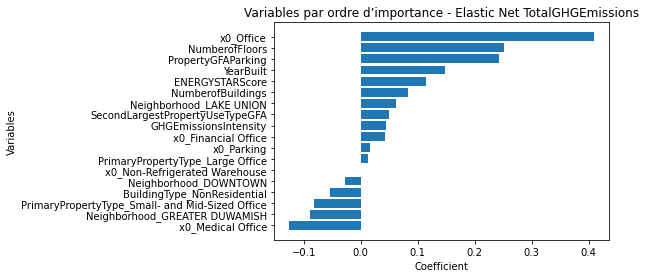

In [140]:
#Affichage des variables par ordre d'importance
plt.barh([x[0] for x in features_i_ela],[x[1] for x in features_i_ela])
plt.title('Variables par ordre d’importance - Elastic Net TotalGHGEmissions')
plt.ylabel('Variables')
plt.xlabel('Coefficient')
#plt.savefig('Coef - Elastic Net TotalGHGEmissions.png')
plt.show()

# Random Forest Regressor - Target variable TotalGHGEmissions

In [141]:
rfr1_Em = RandomForestRegressor(random_state=42)

#### Cross-Validation - 5 folds

On fait une cross-validation avec différentes valeurs pour les hyperparamètre : n_estimators, max_features, max_depth

In [142]:
param_grid_Em = { 
    'n_estimators': [10,20,30],
    'max_features': ['auto', 'sqrt', 'log2'],
    #'max_features': [10, 15, 27],
    'max_depth' : [4,5,6]
}

In [143]:
CV_grid_rfr_Em = GridSearchCV(estimator=rfr1_Em, param_grid=param_grid_Em, cv= 5)
CV_grid_rfr_result_Em = CV_grid_rfr.fit(X_train_Em, Y_train_Em)

In [144]:
CV_grid_rfr_result_Em.best_params_

{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 30}

In [145]:
print('Meilleur Score : ', CV_grid_rfr_result_Em.best_score_)
print('Meilleur Paramètre : ', CV_grid_rfr_result_Em.best_params_)

Meilleur Score :  0.9676769306293227
Meilleur Paramètre :  {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 30}


### Application of best hyperparameters

In [146]:
rfr_Em = RandomForestRegressor(random_state=42)

In [147]:
#Mesurer le temps de calcul - Départ
start_time = timeit.default_timer()

In [148]:
model_Em  = rfr_Em.fit(X_train_Em, Y_train_Em)

In [149]:
y_test_prd_Random_Em = rfr_Em.predict(X_test_Em)
elapsed = timeit.default_timer() - start_time #Mesurer le temps de calcul - Fin
accuracy_Em = rfr_Em.score(X_test_Em, Y_test_Em)

In [150]:
#R2 squarred et performance temporelle
print("accuracy {:.2f} time {:.2f}s".format(accuracy_Em, elapsed))

accuracy 0.98 time 0.45s


In [151]:
results_Em = pd.concat([results_Em, pd.DataFrame.from_records([{'Type de modele' : 'Random Forest',
                          'Best Score' : accuracy_Em,
                          'Hyperparametres' : CV_grid_rfr_result_Em.best_params_,
                          'Temps execution' : elapsed}])])

#### Features Importance - RandomForest

In [152]:
features_Em = X_Em.columns

In [153]:
#Classement des variables par ordre d'importance
features_i_Em = list(zip(features_Em,rfr_Em.feature_importances_)) 
features_i_Em.sort(key = lambda x : x[1]) 

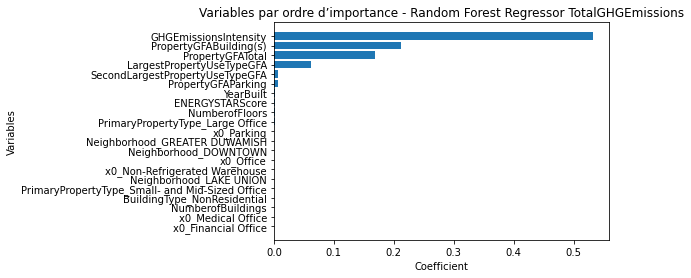

In [154]:
#Affichage des variables les plus importantes
plt.barh([x[0] for x in features_i_Em],[x[1] for x in features_i_Em])
plt.title('Variables par ordre d’importance - Random Forest Regressor TotalGHGEmissions')
plt.ylabel('Variables')
plt.xlabel('Coefficient')
#plt.savefig('Coef - Random Forest Regressor TotalGHGEmissions.png')
plt.show()

In [155]:
results_Em

,Type de modele,Best Score,Hyperparametres,Temps execution
0,Regression lineaire,0.574816,,0.035427
0,Elastic net,0.541132,"{'alpha': 1, 'l1_ratio': 0}",0.029518
0,Random Forest,0.982809,"{'max_depth': 6, 'max_features': 'auto', 'n_es...",0.448029


In [157]:
results

,Type de modele,Best Score,Hyperparametres,Temps execution
0,Regression lineaire,0.630129,,0.066803
0,Elastic Net,0.576653,"{'alpha': 1, 'l1_ratio': 0}",0.145057
0,Random Forest,0.766663,"{'max_depth': 6, 'max_features': 'auto', 'n_es...",0.134442
